In [1576]:
import importlib
import Zer 
import numpy as np
import matplotlib.pyplot as plt
import math
importlib.reload(Zer)
np.set_printoptions(precision=16) 

In [1577]:
loaded_beta = np.load("beta.npy")

5460
     time  x_coordinate  y_coordinate  z_coordinate
0  0.0000     -0.003819      0.000131      0.392065
1  0.0001      0.008713      0.075355      0.385536
2  0.0002      0.016129      0.144790      0.368589
3  0.0003      0.029751      0.229652      0.388273
4  0.0004      0.047213      0.298533      0.387347


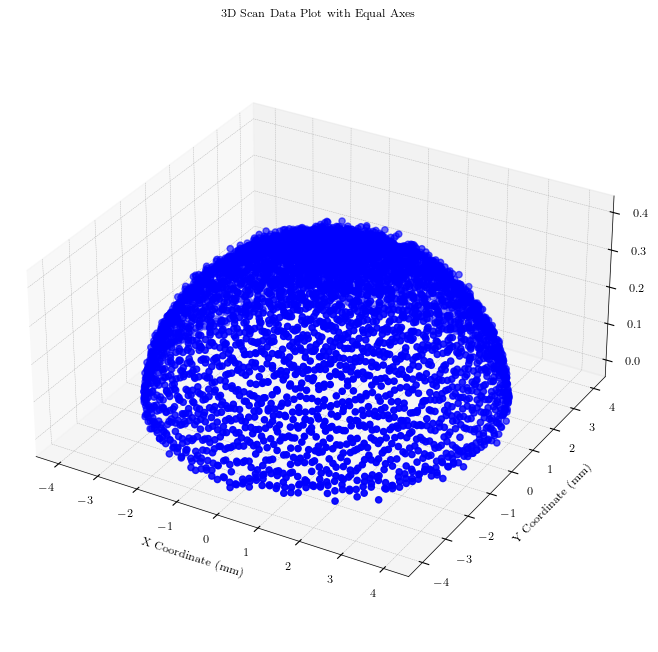

In [1578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
R_SP = 4 # radius in mm
T = 0.546  # period in seconds
a = 16
b = 33
omega = 2 * np.pi / T
sampling_rate = 10000 # in Hz
total_samples = int(T * sampling_rate)  # total samples in one period
print(total_samples)
# Time array
t = np.linspace(0, T, total_samples)
t_cun=t
t1=t[0:2000]
t2=t[2000:4000]
t3=t[4000:]

# Scan pattern equations
noise_level=0.005
x_sp = R_SP * np.sin(a * omega * t)*np.sin(b * omega * t)+np.random.normal(0, noise_level, size=t.shape)
y_sp = R_SP * np.cos(b * omega * t)*np.sin(a * omega * t)+np.random.normal(0, noise_level, size=x_sp.shape)
x=x_sp.flatten()
y=y_sp.flatten()
rho = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
zer= Zer.Zer(14,total_samples,rho,theta)
zer.Construct_Zernike()
z=np.dot(zer.Zernike,loaded_beta)+np.random.normal(0, noise_level*2, size=x_sp.shape)
z_sp=z.reshape(x_sp.shape)
# Update the dataset with z-coordinate
# Creating the dataset
scan_data = pd.DataFrame({
    'time': t,
    'x_coordinate': x_sp,
    'y_coordinate': y_sp,
    'z_coordinate':z_sp
})
filtered_data = scan_data[(scan_data['x_coordinate'] != 0) & (scan_data['y_coordinate'] != 0)]
print(scan_data.head())

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.scatter(scan_data['x_coordinate'], scan_data['y_coordinate'], scan_data['z_coordinate'], c='blue', marker='o')

# Setting equal aspect ratio
ax.set_box_aspect([1,1,0.5])  # Equal aspect ratio

# Labeling the axes
ax.set_xlabel('X Coordinate (mm)')
ax.set_ylabel('Y Coordinate (mm)')
ax.set_zlabel('Z Coordinate (mm)')

# Setting the title
ax.set_title('3D Scan Data Plot with Equal Axes')

# Show plot
plt.show()


In [1579]:
zer1=Zer.Zer(16,total_samples,rho,theta)
Z1=zer1.Construct_Zernike()
inverse=np.linalg.inv(np.dot(Z1.T,Z1))
beta1 = np.dot(inverse,np.dot(Z1.T,z.T))

     time  x_coordinate  y_coordinate  z_coordinate
0  0.0000     -0.003819      0.000131     -0.004027
1  0.0001      0.008713      0.075355      0.002217
2  0.0002      0.016129      0.144790      0.018732
3  0.0003      0.029751      0.229652     -0.001661
4  0.0004      0.047213      0.298533     -0.001438


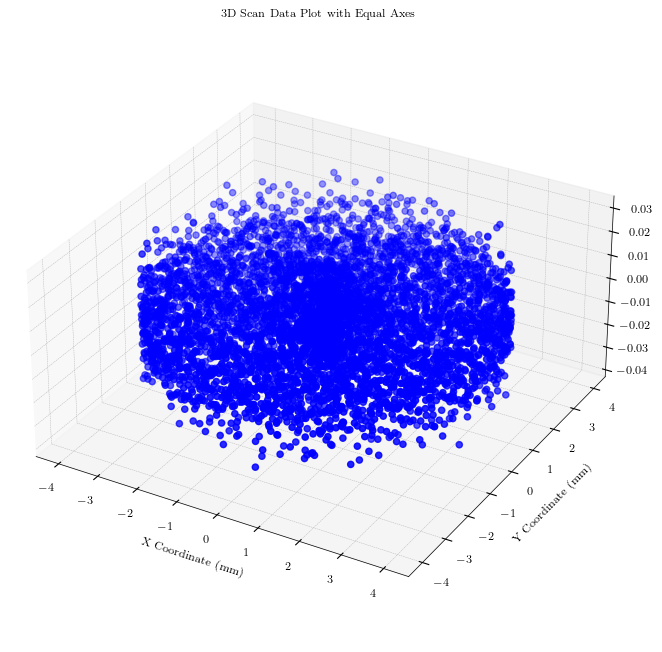

In [1580]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget


z_sp = (np.dot(zer1.Zernike,beta1)-z_sp).reshape(x_sp.shape)
scan_data = pd.DataFrame({
    'time': t_cun,
    'x_coordinate': x,
    'y_coordinate': y,
    'z_coordinate':z_sp
})
filtered_data = scan_data[(scan_data['x_coordinate'] != 0) & (scan_data['y_coordinate'] != 0)]
print(scan_data.head())
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scan_data['x_coordinate'], scan_data['y_coordinate'], scan_data['z_coordinate'], c='blue', marker='o')
ax.set_box_aspect([1,1,0.5]) 
ax.set_xlabel('X Coordinate (mm)')
ax.set_ylabel('Y Coordinate (mm)')
ax.set_zlabel('Z Coordinate (mm)')
ax.set_title('3D Scan Data Plot with Equal Axes')
plt.show()


In [1581]:
zer1=Zer.Zer(6,total_samples,rho,theta)
Z1=zer1.Construct_Zernike()
inverse=np.linalg.inv(np.dot(Z1.T,Z1))
beta1 = np.dot(inverse,np.dot(Z1.T,z.T))
dZ_dx,dZ_dy=zer1.diff(x,y,beta1)
t=[t1,t2,t3]
zer2=Zer.Zer(16,total_samples,rho,theta)
zer2.Construct_Zernike()
C=zer2.Construct_C(t,3,1e14,dZ_dx,dZ_dy)
M=zer2.Construct_M(t,3,dZ_dx,dZ_dy)
Wudi=zer2.Construct_bigmat()
z_wudi=np.hstack((z,np.zeros((6*(zer2.Z_star-1)+3))))
inverse=np.linalg.inv(np.dot(Wudi.T,Wudi))
beta_alpha = np.dot(inverse,np.dot(Wudi.T,z_wudi.T))
beta_ref=beta_alpha[0:zer2.num_poly]
alpha=beta_alpha[zer2.num_poly:]

x_fix,y_fix,z_fix=zer2.Motion(alpha,x,y,z)

4.7293130752303037e-07
3.035258572852976e-07
0.0016610436794884248
1.8047492296943366e-05


In [1582]:
x_fix=x_fix.flatten()
y_fix=y_fix.flatten()
z_fix=z_fix.flatten()
rho_fix = np.sqrt(x_fix**2 + y_fix**2)
theta_fix = np.arctan2(y_fix, x_fix)
zer3=Zer.Zer(16,total_samples,rho_fix,theta_fix)
zer3.Construct_Zernike()
C=zer3.Construct_C(t,3,10000,dZ_dx,dZ_dy)
M=zer3.Construct_M(t,3,dZ_dx,dZ_dy)
Wudi=zer3.Construct_bigmat()

In [1583]:
beta=zer3.Regularization(beta_ref,z_fix)
z_final=np.dot(zer2.Zernike,beta)

     time  x_coordinate  y_coordinate  z_coordinate
0  0.0000     -0.003819      0.000131     -0.000766
1  0.0001      0.008713      0.075355     -0.000935
2  0.0002      0.016129      0.144790     -0.001055
3  0.0003      0.029751      0.229652     -0.001124
4  0.0004      0.047213      0.298533     -0.001105


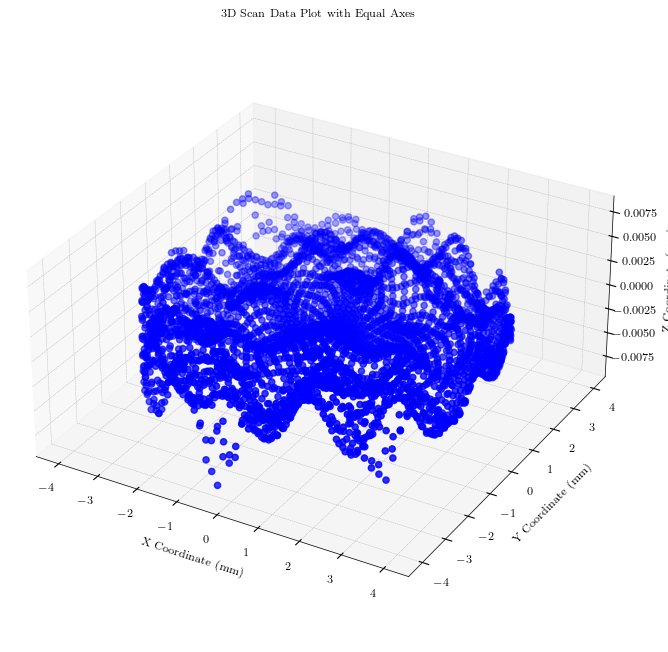

In [1584]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget


x_sp = x_fix.reshape(x_sp.shape)
y_sp = y_fix.reshape(x_sp.shape)
rho = np.sqrt(x_sp**2 + y_sp**2)
theta = np.arctan2(y_sp, x_sp)
zere= Zer.Zer(14,total_samples,rho,theta)
zere.Construct_Zernike()
z_exact=np.dot(zere.Zernike,loaded_beta)
z_sp = (z_final-z_exact).reshape(x_sp.shape)
scan_data = pd.DataFrame({
    'time': t_cun,
    'x_coordinate': x_sp,
    'y_coordinate': y_sp,
    'z_coordinate':z_sp
})
filtered_data = scan_data[(scan_data['x_coordinate'] != 0) & (scan_data['y_coordinate'] != 0)]
print(scan_data.head())
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scan_data['x_coordinate'], scan_data['y_coordinate'], scan_data['z_coordinate'], c='blue', marker='o')
ax.set_box_aspect([1,1,0.5]) 
ax.set_xlabel('X Coordinate (mm)')
ax.set_ylabel('Y Coordinate (mm)')
ax.set_zlabel('Z Coordinate (mm)')
ax.set_title('3D Scan Data Plot with Equal Axes')
plt.show()
